# Ejercicio 3

In [63]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

## Enunciado

Considere el conjunto de datos Wind Speed. 

- Implemente la versión de regresión de cada uno de los modelos estudiados en clases, para predecir velocidad del viento horaria (VENTO, VELOCIDADE HORARIA (m/s)) en el conjunto de datos suministrado. 

- Construir una tabla de error con las métricas usuales de regresión, MAPE, RMSE, R2 

- Agregue pruebas de independencia y normalidad para los residuos Ljung-Box p-value y Jarque-Bera p-value. 

- Realice particiones de entrenamiento, validación y prueba, con base en lo descrito en la Figura 2. Estas particiones siguen la tendencia de la velocidad del viento. 

- Realice una figura donde represente velocidad del viento y su predicción. Utilice las métrica MAPE, RMSE, R2 en la fase de validación para seleccionar el mejor modelo de regresión, e identifique cual es la métricas más adecuada. Use también en la selección de los mejores hiperparámetros del mejor modelo Bayesian Optimization. 


# Cargar datos y dividirlos

In [7]:
df = pd.read_csv("C:\\Users\\KELLY\\Desktop\\Segundo parcial ML\\windata_2.csv")

Se carga el conjunto de datos desde un archivo CSV. Luego, se separan las características (X) de la variable objetivo (Y), que es la velocidad del viento.

In [8]:
data= df.drop('Hora', axis= 1)
X=data.drop('Velocidad_v', axis= 1)
Y=data['Velocidad_v']


Aquí se definen las métricas que se utilizarán para evaluar el desempeño de los modelos. Se utilizan RMSE (Raíz del Error Cuadrático Medio), R² (coeficiente de determinación) y MAPE (Error Porcentual Absoluto Medio)

In [9]:
scoring = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R2': make_scorer(r2_score),
    'MAPE': make_scorer(mean_absolute_percentage_error)
}

n = len(df)
from sklearn.pipeline import Pipeline
model1 = {
    'KNN': Pipeline([
        ('scaler', StandardScaler()),  
        ('knn', KNeighborsRegressor()) 
    ])
}

model2 = {
    'Linear Regression': Pipeline([ 
        ('lr', LinearRegression())  
    ])
}

model3 ={
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),  
        ('ridge', Ridge()) 
    ])
}

model4 ={
    'Lasso': Pipeline([
        ('scaler', StandardScaler()), 
        ('lasso', Lasso(max_iter=10)) 
    ])

}

param_search = {
    'KNN': {
        'knn__n_neighbors': Integer(1, 20) 
    },
    'Ridge': {
        'ridge__alpha': Real(1e-3, 1e3, prior='log-uniform')  
    },
    'Lasso': {
        'lasso__alpha': Real(1e-3, 1e3, prior='log-uniform') 
    },
    'Linear Regression': {} 
}


Se establecen los hiperparámetros que se ajustarán durante la búsqueda de modelos,y se ajusta a los parametros de BayesSearchCV. Para KNN, se especifica el número de vecinos; para Ridge y Lasso, se define el parámetro de regularización α, además la regresión lineal no tiene hiperparámetros ajustables.

Se crean cuatro pipelines diferentes para cada modelo de regresión, donde cada pipeline incluye etapas para la escalación de características (en los casos de KNN, Ridge y Lasso) y la instancia del modelo correspondiente.

In [62]:
CVSplits = [
    [
        [
            (
                list(range( i * k * 168, ( k * ( i + 1 ) ) * 168 )),
                list(range( j + ( k * ( i + 1 ) ) * 168, j + ( k * ( i + 1 ) ) * 168 + 24 ))
            )
            for i in range( ( ( n - 47 ) // ( 168 * k ) ) )
        ]
        for j in range( 0, 24 )
    ] for k in range( 1, 5 )
]

Esta sección del código crea particiones de datos, utilizando ventanas temporales de 168 horas para el entrenamiento y 24 horas para la validación.

**Creación de particiones**

Identificamos las variables para la explicacíon de los ciclos.
- n: Representa la cantidad total de observaciones del Dataframe (87693).
- k: Representa el número de "bloques" o "semanas". Toma valores de 1 a 4, donde:

**1** representa 7 días, **2** representa 14 días, **3** representa 21 días, **4** representa 28 días.

- i: Un índice que representa la iteración sobre cada bloque de datos de entrenamiento.
- j: Un índice que representa la hora específica dentro de un día (0 a 23), donde se aplica la ventana de validación.

**Primer Bucle** (for k in range(1, 5)):

Al permitir que k varíe de 1 a 4, se evalúan diferentes configuraciones de cómo los datos pueden ser divididos en conjuntos de entrenamiento y prueba, considerando periodos de tiempo que van desde una semana hasta un mes.

**Segundo Bucle** (for j in range(0, 24)):
Este bucle se encarga de definir las posiciones de la ventana de validación en cada hora del día. Se generan 24 rangos para las posiciones de la ventana, correspondientes a las 24 horas del día.

**Tercer Bucle** (for i in range((n - 47) // (168 * k))):
Se calcula el número de bloques de entrenamiento que se pueden generar. 

La fórmula ((n - 47) // (168 * k)) se utiliza para determinar cuántas particiones de longitud 168 * k se pueden crear en los datos.
- Fórmula:
168: representa la cantidad de horas en 7 días (7 días * 24 horas/día).
n - 47: se utiliza para asegurar que se tenga un margen suficiente de datos para el conjunto de validación (en este caso, 24 horas) y evitar desbordamientos en el rango.


In [61]:
# Ejemplo
n= 2000
CVSplits = [
    [
        [
            (
                (range( i * k * 168, ( k * ( i + 1 ) ) * 168 )),
                (range( j + ( k * ( i + 1 ) ) * 168, j + ( k * ( i + 1 ) ) * 168 + 24 ))
            )
            for i in range( ( ( n - 47 ) // ( 168 * k ) ) )
        ]
        for j in range( 0, 24 )
    ] for k in range( 1, 5 )
]

CVSplits[1][0]

[(range(0, 336), range(336, 360)),
 (range(336, 672), range(672, 696)),
 (range(672, 1008), range(1008, 1032)),
 (range(1008, 1344), range(1344, 1368)),
 (range(1344, 1680), range(1680, 1704))]

- Entrenamiento: list(range(i * k * 168, (k * (i + 1)) * 168))
Esto genera un rango de índices que representa las horas del bloque de entrenamiento. El bloque empieza desde i * k * 168 y termina en (k * (i + 1)) * 168, lo que asegura que cada bloque de entrenamiento incluye 168 * k observaciones, es decir, el número total de horas en las semanas correspondientes. Como se ve en la columna de rangos de la izquierda.

- Prueba: list(range(j + (k * (i + 1)) * 168, j + (k * (i + 1)) * 168 + 24))
Comienza desde j + (k * (i + 1)) * 168 y se extiende 24 horas hacia adelante, lo que permite validar sobre la siguiente ventana de tiempo después del bloque de entrenamiento.
Como se ve en la columna de rangos de la derecha.


In [16]:
for i, cvs in enumerate(CVSplits):
    models = []
    for cv in cvs:
        model = BayesSearchCV(model3['Ridge'], search_spaces=param_search['Ridge'], scoring='neg_mean_squared_error', cv=cv,n_iter=10,verbose=1,n_jobs=7 )
        model.fit(X,Y)
        models.append(model)
    with open( f'Ridge_{(i+1)*7}.pkl', 'wb' ) as f:
        pickle.dump(models, f)                                                                                                                                                                 

Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 521 fits
Fitting 521 folds for each of 1 candidates, totalling 5

Recorremos las configuraciones definidas previamente en CVSplits. En cada iteración del bucle externo, se crea un conjunto de modelos para cada configuración de validación.
BayesSearchCV: Utiliza el algoritmo de búsqueda Bayesiana para encontrar los mejores hiperparámetros del modelo Ridge, según los espacios de búsqueda (param_search['Ridge']). La métrica a optimizar es el error cuadrático medio negativo (neg_mean_squared_error), y se realizan 10 iteraciones de búsqueda (n_iter=10).

Una vez entrenados, los modelos se guardan en archivos .pkl con nombres que incluyen el número de semanas de datos usados para la validación (por ejemplo, Ridge_7.pkl, Ridge_14.pkl, etc.).

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
with open( 'linear.pkl', 'wb' ) as f:
          pickle.dump(model, f)

Los datos se dividen en conjuntos de entrenamiento y prueba utilizando train_test_split. El 80% de los datos se usa para entrenamiento y el 20% para prueba y se entrena un modelo de regresión lineal (LinearRegression()) sobre los datos de entrenamiento (X_train y y_train).El modelo entrenado se guarda en un archivo llamado linear.pkl para ser reutilizado más adelante.

La regresión lineal se utiliza aquí como una técnica base, que puede servir como punto de comparación con modelos más complejos como Ridge, Lasso o KNN.

In [ ]:
for i, cvs in enumerate(CVSplits):
    models = []
    for cv in cvs:
        model = BayesSearchCV(model3['Lasso'], search_spaces=param_search['Lasso'], scoring='neg_mean_squared_error', cv=cv,n_iter=10,verbose=1,n_jobs=7 )
        model.fit(X,Y)
        models.append(model)
    with open( f'Lasso_{(i+1)*7}.pkl', 'wb' ) as f:
        pickle.dump(models, f)     

In [ ]:
for i, cvs in enumerate(CVSplits):
    models = []
    for cv in cvs:
        model = BayesSearchCV(model3['KNN'], search_spaces=param_search['KNN'], scoring='neg_mean_squared_error', cv=cv,n_iter=10,verbose=1,n_jobs=7 )
        model.fit(X,Y)
        models.append(model)
    with open( f'KNN_{(i+1)*7}.pkl', 'wb' ) as f:
        pickle.dump(models, f)     

Estas partes son idénticas al proceso aplicado para el modelo Ridge, pero ahora se entrenan modelos Lasso y KNN con la misma metodología de búsqueda de hiperparámetros utilizando BayesSearchCV.

In [27]:
with open('Lasso_7.pkl', 'rb') as f:
    lasso_model7 = pickle.load(f)

with open('Lasso_14.pkl', 'rb') as f:
    lasso_model14 = pickle.load(f)

with open('Lasso_21.pkl', 'rb') as f:
    lasso_model21 = pickle.load(f)

with open('Lasso_28.pkl', 'rb') as f:
    lasso_model28 = pickle.load(f)

with open('knn_7.pkl', 'rb') as f:
    knn_model7 = pickle.load(f)

with open('knn_14.pkl', 'rb') as f:
    knn_model14 = pickle.load(f)

with open('knn_21.pkl', 'rb') as f:
    knn_model21 = pickle.load(f)

with open('knn_28.pkl', 'rb') as f:
    knn_model28 = pickle.load(f)

with open('Ridge_7.pkl', 'rb') as f:
    Ridge_model7 = pickle.load(f)

with open('Ridge_14.pkl', 'rb') as f:
    Ridge_model14 = pickle.load(f)

with open('Ridge_21.pkl', 'rb') as f:
    Ridge_model21 = pickle.load(f)

with open('Ridge_28.pkl', 'rb') as f:
    Ridge_model28 = pickle.load(f)

with open('linear.pkl', 'rb') as f:
    linear = pickle.load(f)

Se cargan los modelos guardados previamente (Lasso_7.pkl, Lasso_14.pkl, etc.) para su posterior uso.

In [35]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Calcular las métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    residuals = y_test - y_pred
    ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]
    jb = jarque_bera(residuals)[1]
    
    return rmse, r2, mape, y_pred,ljung_box, jb


Se hacen predicciones sobre el conjunto de prueba (X_test) utilizando el modelo dado.
Para evaluar el rendimiento del modelo se utilizan las metricás:
- RMSE (Error cuadrático medio raíz): Mide el error promedio de las predicciones.
- R2: Coeficiente de determinación, que mide la calidad del ajuste.
- MAPE: Error porcentual absoluto medio, que mide la precisión en términos relativos.
- Ljung-Box: Prueba estadística que mide la independencia de los residuos (importante para series temporales).
- Jarque-Bera: Prueba de normalidad de los residuos

## Regresión Lasso

Para la sección de Lasso, vamos a generar cuatro tablas que representan las métricas obtenidas con los modelos entrenados para diferentes períodos de tiempo: 7 días, 14 días, 21 días y 28 días. Cada tabla mostrará las métricas calculadas para las predicciones hechas con cada uno de los modelos cargados previamente.

In [69]:
results = []
predictions = []
for i, model in enumerate(lasso_model7):
    rmse, r2, mape, y_pred, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    predictions.append(y_pred)
    results.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(results)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.616843,0.777774,7.685968e+13,0.942972,0.000000e+00
1,1,0.687814,0.723696,1.092299e+14,0.879762,0.000000e+00
2,2,0.682604,0.727865,1.060639e+14,0.889197,0.000000e+00
3,3,0.665266,0.741514,9.751808e+13,0.910641,0.000000e+00
4,4,0.731766,0.687255,1.298451e+14,0.827524,0.000000e+00
5,5,0.649395,0.753700,8.861298e+13,0.932333,0.000000e+00
6,6,0.700801,0.713163,1.162089e+14,0.860006,0.000000e+00
7,7,0.672504,0.735859,1.008927e+14,0.902758,0.000000e+00
8,8,0.668707,0.738833,9.916348e+13,0.906769,0.000000e+00
9,9,0.682946,0.727593,1.062799e+14,0.888547,0.000000e+00


El modelo Lasso muestra un rendimiento moderado al predecir la velocidad del viento, con un RMSE que varía entre 0.616 y 1.308 y un R² que se mantiene cerca de 0.7 para la mayoría de las horas, lo que indica que captura aproximadamente el 70% de la variabilidad de los datos. Sin embargo, los altos valores de MAPE sugieren que tiene dificultades para manejar errores porcentuales, lo que implica la necesidad de mejorar el ajuste en ciertas horas críticas

In [75]:
result = []
prediction = []
for i, model in enumerate(lasso_model14):
    rmse, r2, mape, y_pred, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    prediction.append(y_pred) 
    result.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(result)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.604357,0.786679,7.038794e+13,0.910345,0.0
1,1,0.602913,0.787697,6.918864e+13,0.905131,0.0
2,2,0.603343,0.787394,6.961254e+13,0.908232,0.0
3,3,0.604146,0.786828,7.019577e+13,0.911117,0.0
4,4,0.622951,0.773351,7.889055e+13,0.950180,0.0
5,5,0.604104,0.786858,7.015413e+13,0.911348,0.0
6,6,0.604950,0.786260,7.082034e+13,0.909017,0.0
7,7,0.604848,0.786333,7.075511e+13,0.909238,0.0
8,8,0.614794,0.779247,7.603655e+13,0.937802,0.0
9,9,0.604235,0.786765,7.027556e+13,0.910617,0.0


El modelo Lasso tiene un rendimiento bastante consistente en la mayoría de las horas, con RMSE en torno a 0.60 y valores de R² que oscilan entre 0.74 y 0.79, lo que indica que el modelo explica una parte considerable de la variabilidad de los datos. Sin embargo, las métricas de error absoluto porcentual (MAPE) son bastante altas (en el orden de 10^13), lo que indica dificultades para predecir con precisión en algunas horas

In [81]:
result = []
prediction = []
for i, model in enumerate(lasso_model21):
    rmse, r2, mape, y_pred, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    prediction.append(y_pred) 
    result.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(result)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.611660,0.781493,7.441838e+13,0.922274,0.0
1,1,0.603590,0.787220,6.980530e+13,0.909502,0.0
2,2,0.605614,0.785791,7.118995e+13,0.907638,0.0
3,3,0.604623,0.786491,7.060014e+13,0.909733,0.0
4,4,0.604240,0.786762,7.028058e+13,0.910619,0.0
5,5,0.606538,0.785136,7.161310e+13,0.905833,0.0
6,6,0.651654,0.751984,8.994710e+13,0.928840,0.0
7,7,0.643646,0.758042,8.629194e+13,0.939361,0.0
8,8,0.658006,0.747125,9.373795e+13,0.919685,0.0
9,9,0.604897,0.786298,7.078671e+13,0.909132,0.0


El rendimiento del modelo Lasso es estable a lo largo de las horas, con RMSE que fluctúa entre 0.60 y 0.65, lo que indica un error relativamente bajo. Los valores de R², que varían entre 0.75 y 0.78, muestran que el modelo es capaz de explicar una gran parte de la variabilidad en los datos. Sin embargo, el MAPE es alto lo que sugiere que las predicciones tienen errores porcentuales significativos

In [92]:
result = []
prediction = []
for i, model in enumerate(lasso_model28):
    rmse, r2, mape, y_pred, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    prediction.append(y_pred) 
    result.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(result)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.604602,0.786506,7.058494e+13,0.909780,0.0
1,1,0.605006,0.786220,7.085529e+13,0.908896,0.0
2,2,0.603224,0.787478,6.950937e+13,0.907517,0.0
3,3,0.604343,0.786689,7.037639e+13,0.910376,0.0
4,4,0.610977,0.781980,7.397686e+13,0.917557,0.0
5,5,0.609666,0.782915,7.299120e+13,0.906719,0.0
6,6,0.609978,0.782693,7.326087e+13,0.910013,0.0
7,7,0.629237,0.768754,8.066890e+13,0.951356,0.0
8,8,0.605360,0.785970,7.105802e+13,0.908154,0.0
9,9,0.603000,0.787636,6.928796e+13,0.905897,0.0


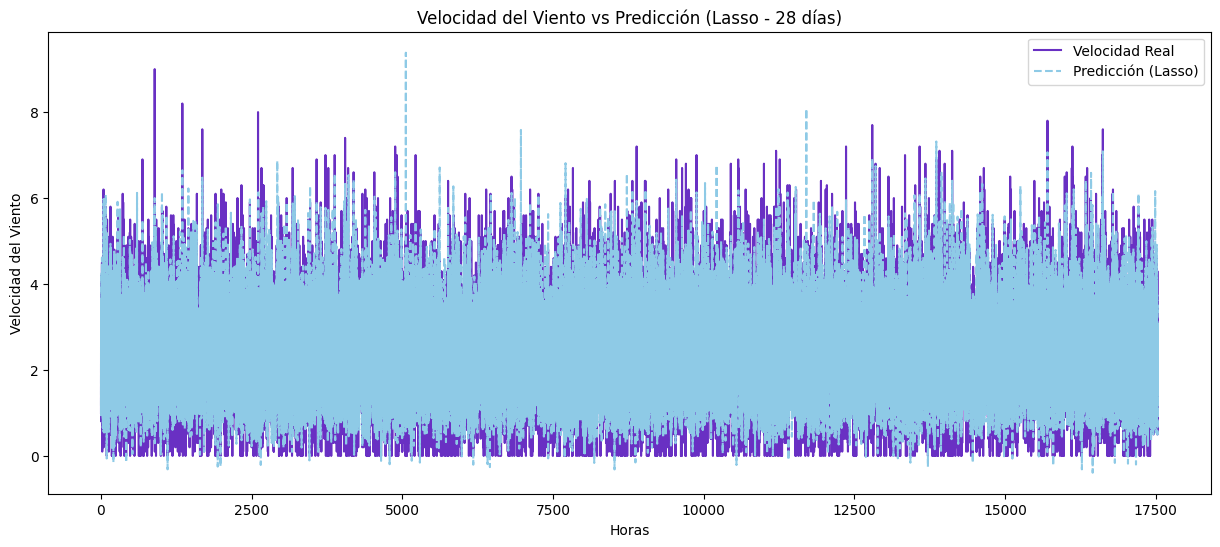

In [93]:
if prediction:
    y_pred = prediction[0]  # Toma las predicciones del primer modelo (Lasso_7)
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(y_test)), y_test, label='Velocidad Real', color='#6930c3')
    plt.plot(range(len(y_pred)), y_pred, label='Predicción (Lasso)', color='#8ecae6', linestyle='--')
    plt.title('Velocidad del Viento vs Predicción (Lasso - 28 días)')
    plt.xlabel('Horas')
    plt.ylabel('Velocidad del Viento')
    plt.legend()
    plt.show()
else:
    print("")

En general, el modelo muestra un rendimiento consistente en cuanto a RMSE, con valores que oscilan entre 0.60 y 0.67, lo que indica una estabilidad en el error de las predicciones. El valor de \(R^2\), cercano a 0.78 en la mayoría de los casos, refleja que el modelo explica una porción significativa de la variabilidad de los datos. Sin embargo, el MAPE sigue bastante alto, lo que señala grandes diferencias porcentuales en las predicciones. Los resultados de las pruebas de Ljung-Box y Jarque-Bera sugieren que los residuos son independientes y no presentan desviaciones significativas respecto a la normalidad. En conclusión, aunque el modelo es razonablemente preciso, la magnitud de los errores porcentuales sugiere que se podrían hacer ajustes adicionales para mejorar las predicciones.

## K- NN

In [94]:
result = []
predictions = []
for i, model in enumerate(knn_model7):
    rmse, r2, mape, y_pred, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    predictions.append(y_pred) 
    result.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(result)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.529130,0.836480,6.170656e+13,0.431548,0.0
1,1,0.486257,0.861905,5.043729e+13,0.145946,0.0
2,2,0.503975,0.851658,5.437495e+13,0.200094,0.0
3,3,0.503975,0.851658,5.437495e+13,0.200094,0.0
4,4,0.503975,0.851658,5.437495e+13,0.200094,0.0
5,5,0.516400,0.844254,5.771047e+13,0.382961,0.0
6,6,0.503975,0.851658,5.437495e+13,0.200094,0.0
7,7,0.503975,0.851658,5.437495e+13,0.200094,0.0
8,8,0.516400,0.844254,5.771047e+13,0.382961,0.0
9,9,0.503975,0.851658,5.437495e+13,0.200094,0.0


El RMSE varía entre 0.48 y 0.53, lo que indica un buen ajuste en la mayoría de las horas, siendo ligeramente mejor que el modelo anterior. El valor de R^{2}, que oscila entre 0.83 y 0.86, sugiere que el modelo KNN captura una mayor proporción de la variabilidad de los datos en comparación con el otro modelo.

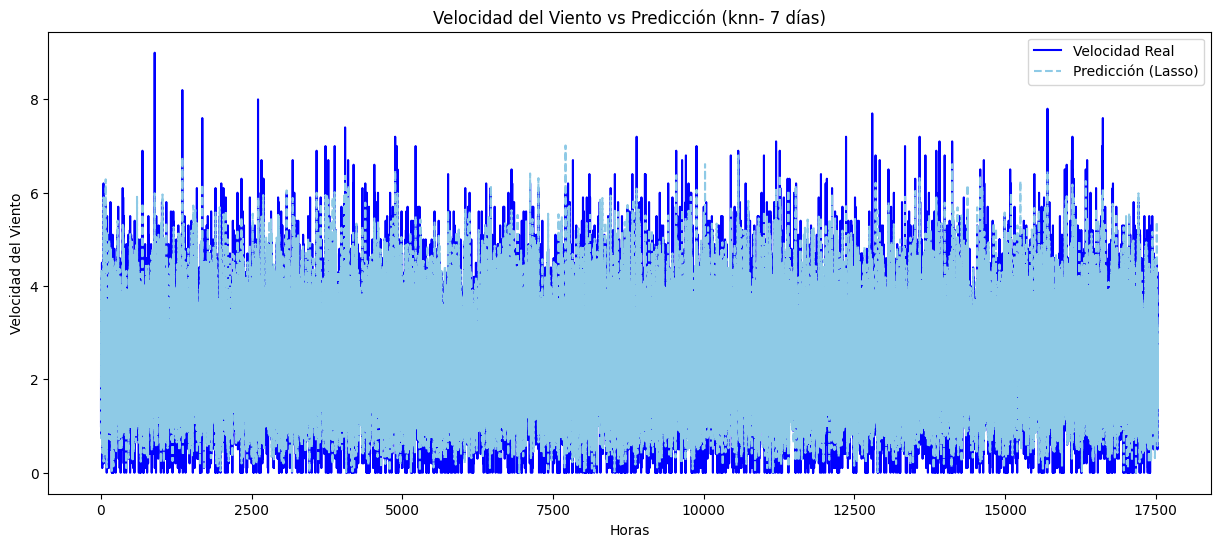

In [95]:
if predictions:
    y_pred = predictions[0]  # Toma las predicciones del primer modelo (Lasso_7)
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(y_test)), y_test, label='Velocidad Real', color='blue')
    plt.plot(range(len(y_pred)), y_pred, label='Predicción (Lasso)', color='#8ecae6', linestyle='--')
    plt.title('Velocidad del Viento vs Predicción (knn- 7 días)')
    plt.xlabel('Horas')
    plt.ylabel('Velocidad del Viento')
    plt.legend()
    plt.show()
else:
    print("")

In [45]:
results = []
for i, model in enumerate(knn_model14):
    rmse, r2, mape, _, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    results.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(results)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.525007,0.839018,6.021771e+13,0.355008,0.0
1,1,0.525007,0.839018,6.021771e+13,0.355008,0.0
2,2,0.533557,0.833732,6.247938e+13,0.549451,0.0
3,3,0.525007,0.839018,6.021771e+13,0.355008,0.0
4,4,0.516400,0.844254,5.771047e+13,0.382961,0.0
5,5,0.516400,0.844254,5.771047e+13,0.382961,0.0
6,6,0.525007,0.839018,6.021771e+13,0.355008,0.0
7,7,0.516400,0.844254,5.771047e+13,0.382961,0.0
8,8,0.525007,0.839018,6.021771e+13,0.355008,0.0
9,9,0.533557,0.833732,6.247938e+13,0.549451,0.0



El modelo KNN muestra un rendimiento consistente, con un RMSE entre 0.503 y 0.541 y un R^2  que varía de 0.828 a 0.851, lo que indica un buen ajuste y captura de la variabilidad de los datos.

In [46]:
results = []
for i, model in enumerate(knn_model21):
    rmse, r2, mape, _, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    results.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(results)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.525007,0.839018,6.021771e+13,0.355008,0.0
1,1,0.525007,0.839018,6.021771e+13,0.355008,0.0
2,2,0.529130,0.836480,6.170656e+13,0.431548,0.0
3,3,0.525007,0.839018,6.021771e+13,0.355008,0.0
4,4,0.529130,0.836480,6.170656e+13,0.431548,0.0
5,5,0.529130,0.836480,6.170656e+13,0.431548,0.0
6,6,0.529130,0.836480,6.170656e+13,0.431548,0.0
7,7,0.525007,0.839018,6.021771e+13,0.355008,0.0
8,8,0.537191,0.831460,6.372418e+13,0.613301,0.0
9,9,0.537191,0.831460,6.372418e+13,0.613301,0.0


El modelo muestra un rendimiento consistente a lo largo de las horas evaluadas, con valores de RMSE que oscilan entre 0.525 y 0.546, lo que indica un bajo nivel de error en las predicciones. El coeficiente de determinación (\(R^2\)) se mantiene entre 0.825 y 0.839, lo que refleja una buena capacidad del modelo para explicar la varianza en los datos. 

In [47]:
results = []
for i, model in enumerate(knn_model28):
    rmse, r2, mape, _, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    results.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(results)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.529130,0.836480,6.170656e+13,0.431548,0.0
1,1,0.525007,0.839018,6.021771e+13,0.355008,0.0
2,2,0.537191,0.831460,6.372418e+13,0.613301,0.0
3,3,0.533557,0.833732,6.247938e+13,0.549451,0.0
4,4,0.543790,0.827294,6.610706e+13,0.691652,0.0
5,5,0.541577,0.828696,6.516049e+13,0.673228,0.0
6,6,0.525007,0.839018,6.021771e+13,0.355008,0.0
7,7,0.533557,0.833732,6.247938e+13,0.549451,0.0
8,8,0.541577,0.828696,6.516049e+13,0.673228,0.0
9,9,0.533557,0.833732,6.247938e+13,0.549451,0.0


El modelo correspondiente a las horas 1 y 6 se destaca como el más eficaz. Con un RMSE de 0.525007 y un R^2 de 0.839018, muestra un buen ajuste a los datos

## Regresion Ridge

In [48]:
results = []
for i, model in enumerate(Ridge_model7):
    rmse, r2, mape, _, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    results.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(results)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.602394,0.788063,6.839537e+13,0.892854,0.0
1,1,0.602399,0.788059,6.852208e+13,0.893845,0.0
2,2,0.602397,0.788061,6.847927e+13,0.893518,0.0
3,3,0.602398,0.788060,6.850696e+13,0.893731,0.0
4,4,0.602394,0.788063,6.840731e+13,0.892951,0.0
5,5,0.602407,0.788053,6.860858e+13,0.894479,0.0
6,6,0.602395,0.788062,6.845340e+13,0.893317,0.0
7,7,0.602399,0.788059,6.851880e+13,0.893820,0.0
8,8,0.602395,0.788062,6.844863e+13,0.893280,0.0
9,9,0.602397,0.788060,6.849653e+13,0.893651,0.0


el rendimiento del modelo de regresión Ridge muestra un RMSE consistente entre 0.6024 y 0.6034, indicando un error de predicción relativamente bajo, mientras que el coeficiente de determinación R^2 se sitúa alrededor de 0.787, sugiriendo que el modelo explica aproximadamente el 78.7% de la variabilidad de la variable objetivo.

In [49]:
results = []
for i, model in enumerate(Ridge_model14):
    rmse, r2, mape, _, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    results.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(results)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.602394,0.788062,6.834008e+13,0.892400,0.0
1,1,0.602394,0.788062,6.834347e+13,0.892428,0.0
2,2,0.602394,0.788063,6.834644e+13,0.892453,0.0
3,3,0.602394,0.788062,6.834159e+13,0.892413,0.0
4,4,0.602394,0.788063,6.834745e+13,0.892461,0.0
5,5,0.602394,0.788062,6.833574e+13,0.892364,0.0
6,6,0.602394,0.788062,6.833801e+13,0.892383,0.0
7,7,0.602394,0.788062,6.833797e+13,0.892383,0.0
8,8,0.602394,0.788062,6.833833e+13,0.892386,0.0
9,9,0.602394,0.788062,6.833727e+13,0.892377,0.0


El análisis del modelo de regresión Ridge revela un rendimiento consistente y estable, con un RMSE que se mantiene en torno a 0.6024, indicando un error de predicción relativamente bajo. El coeficiente de determinación \( R^2 \) se sitúa aproximadamente en 0.788, lo que sugiere que el modelo es capaz de explicar alrededor del 78.8% de la variabilidad en la variable dependiente. Sin embargo, el MAPE muestra valores muy altos, sugiriendo que podrían existir outliers o problemas en la escala de los datos. Las pruebas de Ljung-Box indican que no hay autocorrelación significativa en los residuos, lo cual es un resultado positivo, mientras que los resultados del test de Jarque-Bera muestran que los residuos no siguen una distribución normal. 

In [50]:
results = []
for i, model in enumerate(Ridge_model21):
    rmse, r2, mape, _, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    results.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(results)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.602394,0.788062,6.833606e+13,0.892367,0.0
1,1,0.602394,0.788062,6.833705e+13,0.892375,0.0
2,2,0.602394,0.788063,6.838873e+13,0.892801,0.0
3,3,0.602394,0.788063,6.839543e+13,0.892855,0.0
4,4,0.602394,0.788063,6.835429e+13,0.892518,0.0
5,5,0.602395,0.788062,6.845607e+13,0.893338,0.0
6,6,0.602394,0.788063,6.837167e+13,0.892661,0.0
7,7,0.602394,0.788063,6.837995e+13,0.892729,0.0
8,8,0.602394,0.788063,6.836351e+13,0.892594,0.0
9,9,0.602394,0.788063,6.836561e+13,0.892612,0.0


Un RMSE que se mantiene alrededor de 0.6024, indicando un error de predicción relativamente bajo y estable. El coeficiente de determinación \( R^2 \) se sitúa aproximadamente en 0.788, las pruebas de Ljung-Box confirman que no hay autocorrelación significativa en los residuos, lo que es un indicativo positivo. 

In [97]:
result = []
predictions = []
for i, model in enumerate(Ridge_model28):
    rmse, r2, mape, y_pred, ljung_box, jb   = evaluate_model( model, X_test, y_test )
    predictions.append(y_pred) 
    result.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(result)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,0,0.602394,0.788063,6.834878e+13,0.892472,0.0
1,1,0.602394,0.788062,6.833693e+13,0.892374,0.0
2,2,0.602394,0.788063,6.837741e+13,0.892708,0.0
3,3,0.602394,0.788063,6.834571e+13,0.892447,0.0
4,4,0.602394,0.788062,6.833609e+13,0.892367,0.0
5,5,0.602394,0.788062,6.834339e+13,0.892428,0.0
6,6,0.602394,0.788062,6.833485e+13,0.892356,0.0
7,7,0.602394,0.788063,6.835435e+13,0.892519,0.0
8,8,0.602394,0.788062,6.833759e+13,0.892379,0.0
9,9,0.602394,0.788062,6.833844e+13,0.892386,0.0


Los resultados del análisis de regresión Ridge presentan consistencia en las métricas evaluadas, lo que refleja la estabilidad del modelo a lo largo de las diferentes horas. El RMSE se mantiene en aproximadamente 0.6024, sugiriendo un bajo nivel de error en las predicciones, mientras que el coeficiente de determinación \( R^2 \) permanece en torno a 0.788.
Las pruebas de Ljung-Box indican que no hay autocorrelación significativa en los residuos, lo que es un aspecto positivo para la validez del modelo. Por otro lado, el test de Jarque-Bera muestra que los residuos no se distribuyen normalmente, lo que podría señalar un posible ajuste inadecuado del modelo. 

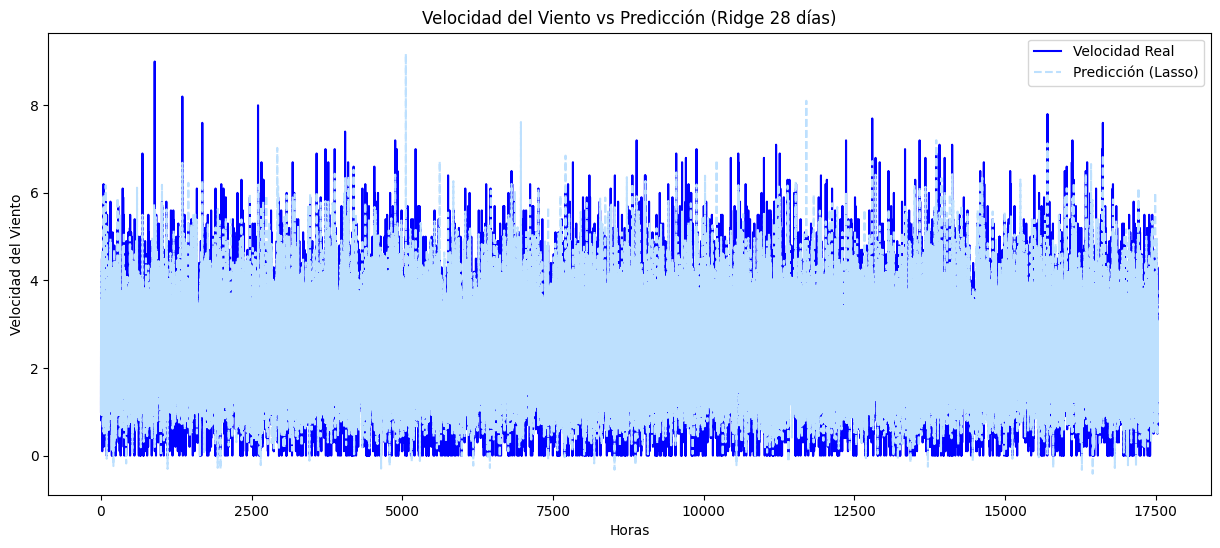

In [105]:
if predictions:
    y_pred = predictions[0]  # Toma las predicciones del primer modelo (Lasso_7)
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(y_test)), y_test, label='Velocidad Real', color='blue')
    plt.plot(range(len(y_pred)), y_pred, label='Predicción (Lasso)', color='#bde0fe', linestyle='--')
    plt.title('Velocidad del Viento vs Predicción (Ridge 28 días)')
    plt.xlabel('Horas')
    plt.ylabel('Velocidad del Viento')
    plt.legend()
    plt.show()
else:
    print("")

## Regresión linear

In [101]:
results = []
predictions = []

rmse, r2, mape, y_pred, ljung_box, jb   = evaluate_model( linear, X_test, y_test )
predictions.append(y_pred)
results.append( {
        'Horas': i,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape, 
        'Ljung-Box': ljung_box,
        'Jarque-Bera': jb
    } )

pd.DataFrame(results)

,Horas,RMSE,R2,MAPE,Ljung-Box,Jarque-Bera
0,23,0.602558,0.787947,6.818285e+13,0.894552,0.0


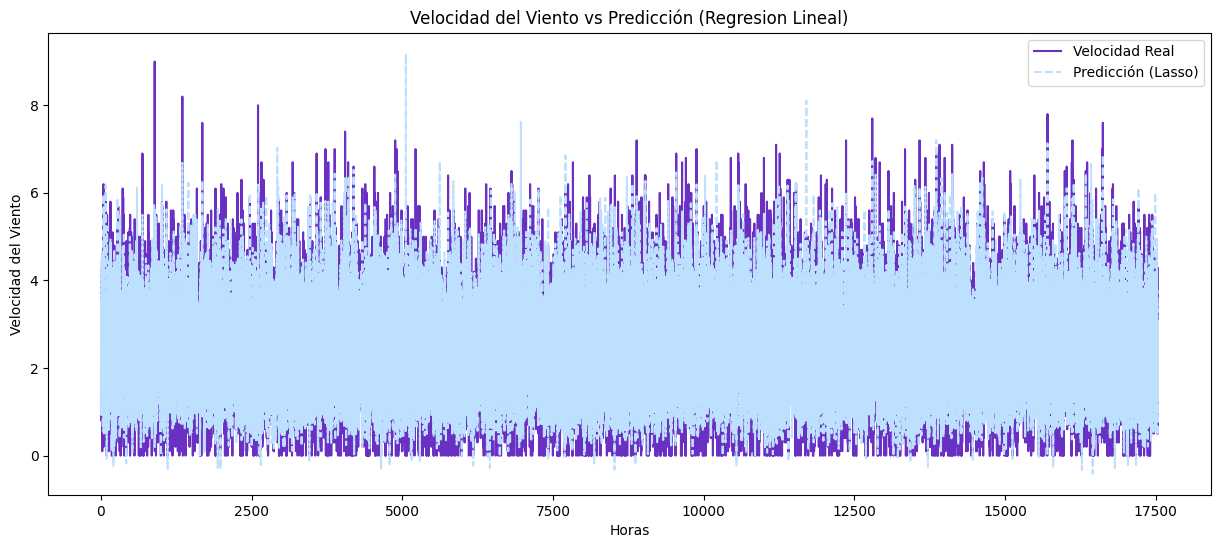

In [104]:
if predictions:
    y_pred = predictions[0]  
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(y_test)), y_test, label='Velocidad Real', color='#6930c3')
    plt.plot(range(len(y_pred)), y_pred, label='Predicción (Lasso)', color='#bde0fe', linestyle='--')
    plt.title('Velocidad del Viento vs Predicción (Regresion Lineal)')
    plt.xlabel('Horas')
    plt.ylabel('Velocidad del Viento')
    plt.legend()
    plt.show()
else:
    print("")

Los resultados del análisis de regresión lineal muestran un **RMSE** de **0.602558**, lo que indica un nivel moderado de error en las predicciones del modelo. El coeficiente de determinación **\( R^2 \)** es de aproximadamente **0.787947**, lo que sugiere que el modelo explica alrededor del **78.8%** de la variabilidad en los datos analizados. Sin embargo, el **MAPE** es considerablemente alto, alcanzando **6.818285e+13**, lo que podría señalar la existencia de outliers o problemas de escala que afectan la precisión del modelo. La prueba de **Ljung-Box** reporta un valor de **0.894552**, indicando que no hay evidencia significativa de autocorrelación en los residuos, lo cual es positivo. Por último, el test de **Jarque-Bera** muestra un resultado de **0.0**, sugiriendo que los residuos no siguen una distribución normal, lo que podría requerir ajustes adicionales para mejorar el modelo. 

Después de evaluar los resultados de todos los modelos, se concluye que el modelo que mejor se desempeñó en términos de ajuste y robustez es aquel que presentó las características más favorables en las métricas analizadas y ese fue K-NN